### Data Mining Final - Recommendation System

In [3]:
#!pip install surprise

In [4]:
# For data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from surprise import Dataset, Reader

In [5]:
import sys
print (sys.version)

import time

3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


In [6]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

16

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "15" # Change '15' to the number of cores 


In [8]:
#setting all dataframes
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

**We already explored how clean the data is in part 1. Let's do some pre-processing:**

#### 1 Merging, Consolidating, etc.

In [9]:
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


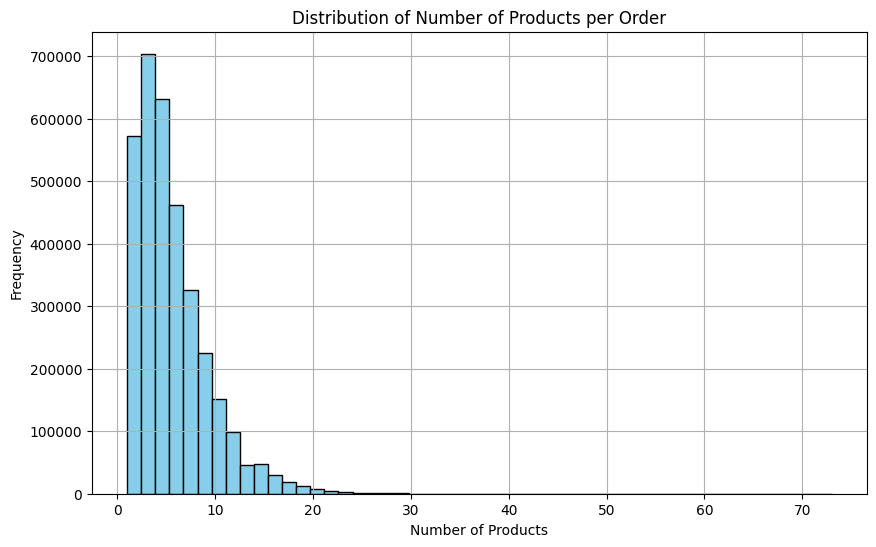

In [10]:
# Group by order_id and calculate the mean of add_to_cart_order
average_products_per_order = merged_order_products.groupby('order_id')['add_to_cart_order'].mean()

# Display the most common number of products per order
# Plot a histogram of the number of products per order
plt.figure(figsize=(10, 6))
plt.hist(average_products_per_order, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
# Display summary statistics of the number of products per order
summary_statistics = average_products_per_order.describe()
print("Summary Statistics of Number of Products per Order:")
print(summary_statistics)


Summary Statistics of Number of Products per Order:
count    3.346083e+06
mean     5.553537e+00
std      3.771163e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.500000e+00
75%      7.500000e+00
max      7.300000e+01
Name: add_to_cart_order, dtype: float64


In [12]:
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [13]:
consolidated_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
consolidated_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


Final step is to merge with what products are ordered.

In [14]:
final_merged_orders = pd.merge(orders, consolidated_products_desc, on = 'order_id')
final_merged_orders.head() 

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


**This final merged DataFrame provides a complete overview of orders, including user IDs, order sequences, ordering times, and detailed product information.**

Again, just to recap -- We can split all of the data into 3 clear types:

- Historical Data: Records the order history for each user.
- Training Data: Contains the latest order information for each user, limited to one order per user.
- **Testing Data**: Represents the anticipated future orders of each user, lacking any product details (which are to be predicted).

In [15]:
final_merged_orders[final_merged_orders['user_id']==1]['product_name'].value_counts()

product_name
Soda                                       11
Original Beef Jerky                        10
Pistachios                                 10
Organic String Cheese                       9
Cinnamon Toast Crunch                       4
Zero Calorie Cola                           4
XL Pick-A-Size Paper Towel Rolls            3
Aged White Cheddar Popcorn                  3
Organic Half & Half                         3
Bag of Organic Bananas                      2
0% Greek Strained Yogurt                    2
Milk Chocolate Almonds                      2
Organic Unsweetened Vanilla Almond Milk     1
Creamy Almond Butter                        1
Bartlett Pears                              1
Honeycrisp Apples                           1
Organic Fuji Apples                         1
Organic Unsweetened Almond Milk             1
Organic Whole Milk                          1
Name: count, dtype: int64

### 2. Prepping the Data for a Recommendation System.

The term "Surprise" stands for Simple Python RecommendatIon System Engine. It's a popular tool among data scientists and researchers for its flexibility, ease of use, and efficiency in handling various recommendation system tasks.

- Various Algorithms: Surprise provides a wide range of ready-to-use prediction algorithms, including baseline algorithms, neighborhood methods (e.g., KNN), matrix factorization-based algorithms (such as SVD, SVD++, NMF), and many others. 

- Customization: It allows for the development and testing of custom algorithms, making it a flexible choice for experimenting with novel recommendation approaches.

- Benchmarking: Surprise facilitates easy algorithm benchmarking with built-in datasets to compare the performance of different algorithms on standard metrics like RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). 

- Dataset Handling: It comes with tools for loading custom user-item rating datasets from Pandas dataframes or from disk, as well as built-in datasets for quick experiments and testing. 

- Cross-validation and Hyperparameter Tuning: Surprise supports cross-validation procedures and provides tools for hyperparameter tuning to optimize algorithm performance.

**2.1: Problem - there is inherently not a 'rating' for how well each user would purchase an item. We could (1) consider an implicit approach with a simple binary interpretation of reordered or not... or (2) count the number of times a product was purchased by each user, essentially treating the reorder count as a proxy for user preference or product popularity.**

To create a more nuanced recommendation system using the final_merged_orders dataset and incorporating ideas from both approaches, we can develop a 'rating' that considers both the presence of reordering (as an implicit positive signal) and the frequency of reorders (to capture the strength of user preference). This combined approach leverages the reorder counts while also utilizing binary reorder data to enhance the recommendation system's understanding of user preferences.

In [16]:
#!pip install surprise

#### 2.2: Step 1: Initial Data Processing

Start by marking all orders as positive interactions but with varying strengths based on whether they are reorders and how often reordering occurs.

In [17]:
import pandas as pd
from surprise import Dataset, Reader

# Mark every order as a positive interaction, with more weight if it's a reorder
final_merged_orders['interaction'] = 1.0
final_merged_orders.loc[final_merged_orders['reordered'] == 1, 'interaction'] += 1.0  # Boost reorders


#### Step 2: Aggregate Reorder Frequencies

Aggregate reorder frequencies to understand how frequently each product was reordered by each user, adding this as an additional weight.

In [18]:
# Count total orders and reorders for each user-product combination
reorder_counts = final_merged_orders.groupby(['user_id', 'product_id']).agg(
    total_orders=pd.NamedAgg(column='interaction', aggfunc='count'),
    reorders=pd.NamedAgg(column='reordered', aggfunc='sum')
).reset_index()

# Calculate a reorder frequency score as additional weight
# Logic: Higher frequency of reordering indicates stronger preference
reorder_counts['reorder_score'] = reorder_counts['reorders'] / reorder_counts['total_orders']

# Normalize reorder_score to have a minimum of 1 (for items ordered only once, without reorders)
reorder_counts['reorder_weight'] = 1 + reorder_counts['reorder_score']


#### Step 3: Combine Interaction Strength and Reorder Weight

In [19]:
# Merge the reorder weight back into the original orders data
final_data = pd.merge(final_merged_orders, reorder_counts[['user_id', 'product_id', 'reorder_weight']], on=['user_id', 'product_id'])

# Use the product of 'interaction' and 'reorder_weight' as the final rating
final_data['rating'] = final_data['interaction'] * final_data['reorder_weight']


In [20]:
final_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,interaction,reorder_weight,rating
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages,1.0,1.909091,1.909091
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182


In [21]:
# Specify the file path and name for your CSV file
file_path = 'processed_final_merged_orders.parquet'

# Save the DataFrame to a CSV file
final_data.to_parquet(file_path, index=False)


####  Assessing the distribution of the 'rating'. Exploring if it's good or not/

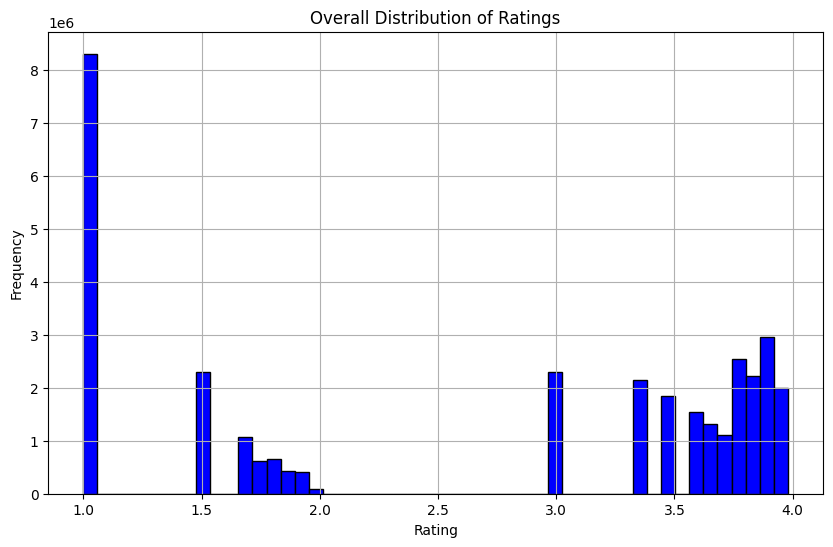

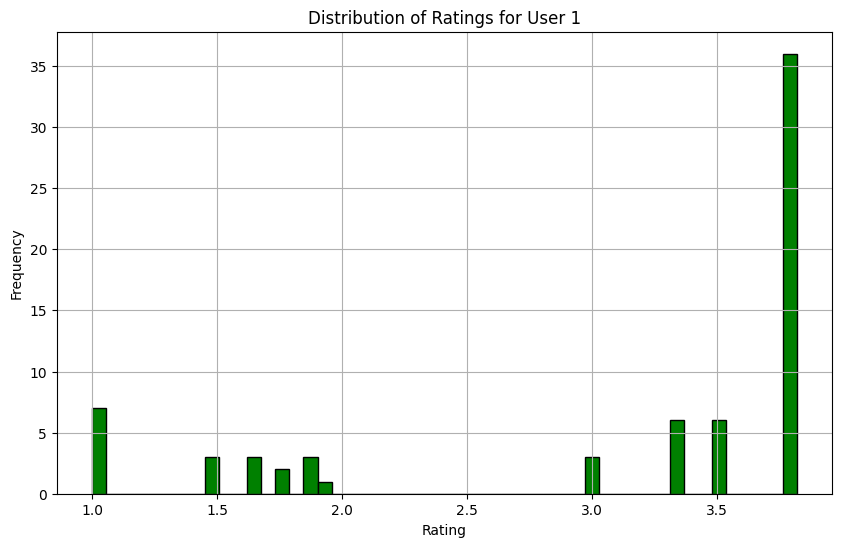

(count    3.381911e+07
 mean     2.660972e+00
 std      1.203552e+00
 min      1.000000e+00
 25%      1.500000e+00
 50%      3.333333e+00
 75%      3.777778e+00
 max      3.980000e+00
 Name: rating, dtype: float64,
 count    70.000000
 mean      3.062886
 std       1.028553
 min       1.000000
 25%       1.902273
 50%       3.777778
 75%       3.800000
 max       3.818182
 Name: rating, dtype: float64)

In [22]:
import matplotlib.pyplot as plt

# Overall distribution of 'rating'
plt.figure(figsize=(10, 6))
plt.hist(final_data['rating'], bins=50, color='blue', edgecolor='black')
plt.title('Overall Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Distribution of 'rating' for a specific user (e.g., user_id=1)
user_1_ratings = final_data[final_data['user_id'] == 1]['rating']

plt.figure(figsize=(10, 6))
plt.hist(user_1_ratings, bins=50, color='green', edgecolor='black')
plt.title('Distribution of Ratings for User 1')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display summary statistics for overall ratings and for User 1
overall_summary = final_data['rating'].describe()
user_1_summary = user_1_ratings.describe()

(overall_summary, user_1_summary)


Not bad. can make more big or narrow.

#### Step 4: Transforming the data into format compatible with Surprise

In [23]:
final_data = pd.read_parquet('processed_final_merged_orders.parquet')

In [24]:
final_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,interaction,reorder_weight,rating
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages,1.0,1.909091,1.909091
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages,2.0,1.909091,3.818182


In [25]:
# Define the rating scale dynamically based on the possible range of 'rating'
rating_scale = (final_data['rating'].min(), final_data['rating'].max())
reader = Reader(rating_scale=rating_scale)


In [26]:
#### IF YOU NEED A SAMPLE TO TEST.
sample_df = final_data.sample(frac=0.1)  # Sample 10% of the data


In [27]:
# Load the dataset
data = Dataset.load_from_df(final_data[['user_id', 'product_id', 'rating']], reader)

In [28]:
###########

### 3.1 Choosing a recommendation algorithm

In [29]:
from surprise import SVD
algo = SVD()


### 3.2 -  Train-Test Split and Model Training

In [30]:
%%time

from surprise.model_selection import train_test_split
from surprise import accuracy

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 0.9822
CPU times: user 12min 38s, sys: 7.22 s, total: 12min 46s
Wall time: 12min 45s


0.982198116927171

### 3.3 - Evaluating the model. understanding what everything is. Putting common sense behind it -- 

In [31]:
len(testset)

8454777

In [32]:
if predictions:
    print(f"Number of predictions made: {len(predictions)}")
else:
    print("No predictions were made.")


Number of predictions made: 8454777


**Examining the Predictions:**

In [33]:
for pred in predictions[:5]:
    print(f"User: {pred.uid}, Item: {pred.iid}, Estimated Rating: {pred.est:.2f}")


User: 33928, Item: 47611, Estimated Rating: 3.26
User: 13332, Item: 13176, Estimated Rating: 2.58
User: 118221, Item: 39619, Estimated Rating: 3.14
User: 630, Item: 49141, Estimated Rating: 3.66
User: 174934, Item: 17600, Estimated Rating: 2.71


**Check format is ok:**

In [38]:
# Example: Check the format of user IDs in the test set and predictions
print(f"Test set user ID format example: {testset[0][0]}")
print(f"Prediction user ID format example: {predictions[0].uid}")


Test set user ID format example: 33928
Prediction user ID format example: 33928


**Identify Items Actually Purchased by the User**

In [41]:
# 1) Top 10 unique products actually purchased by user 33928 and their corresponding names

# Extracting orders made by user 33928
user_33928_orders = final_merged_orders[final_merged_orders['user_id'] == 33928]

# Extracting unique products purchased by user 33928
unique_products_33928 = user_33928_orders[['product_id', 'product_name']].drop_duplicates()

# Counting the frequency of each product purchased by user 33928
product_counts_33928 = user_33928_orders.groupby(['product_id', 'product_name']).size().reset_index(name='purchase_count')

# Sorting the products by purchase frequency in descending order to get top 10 items
top_products_purchased_33928 = product_counts_33928.sort_values(by='purchase_count', ascending=False).head(10)

top_products_purchased_33928


,product_id,product_name,purchase_count
40,19934,Fat Free Smooth & Creamy Plain Organic Yogurt,20
15,6201,Bite Size Tortilla Chips,17
71,38948,Petit Ecolier Milk Chocolate Biscuits,13
12,5323,Organic Strawberry Lowfat Yogurt Smoothie,10
65,37836,Milano Milk Chocolate Cookies,10
54,29698,Snack Stacks! Original Potato Crisps,9
76,40627,Peach Preserves,8
55,30352,Goldfish Original Baked Snack Crackers,8
1,1017,Strawberry Banana Juice,8
16,6448,Smartfood White Cheddar Cheese Popcorn,7


**Evaluate Model Errors (No Prediction yet, just analysis of the errors)**

In [46]:
# Step 1: Top 10 Unique Products Purchased by User 33928
user_33928_data = final_data[final_data['user_id'] == 33928]
top_10_products_33928 = user_33928_data.groupby('product_id').agg(
    actual_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    product_name=pd.NamedAgg(column='product_name', aggfunc='first')
).nlargest(10, 'actual_rating').reset_index()

# Predict ratings for these top 10 products
top_10_products_33928['predicted_rating'] = top_10_products_33928['product_id'].apply(
    lambda x: algo.predict(33928, x).est
)

# Display the table for top 10 items
top_10_products_33928_display = top_10_products_33928[['product_name', 'actual_rating', 'predicted_rating']]
print(top_10_products_33928_display)

                                    product_name  actual_rating  \
0  Fat Free Smooth & Creamy Plain Organic Yogurt       3.802500   
1                       Bite Size Tortilla Chips       3.768166   
2          Petit Ecolier Milk Chocolate Biscuits       3.698225   
3      Organic Strawberry Lowfat Yogurt Smoothie       3.610000   
4                  Milano Milk Chocolate Cookies       3.610000   
5           Snack Stacks! Original Potato Crisps       3.567901   
6                        Strawberry Banana Juice       3.515625   
7         Goldfish Original Baked Snack Crackers       3.515625   
8                                Peach Preserves       3.515625   
9                  Baked Snack Crackers Original       3.448980   

   predicted_rating  
0          3.788173  
1          3.704713  
2          3.641263  
3          3.620676  
4          3.233020  
5          3.321303  
6          3.327210  
7          3.696592  
8          3.551363  
9          3.122543  


/tmp/ipykernel_145/76483607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_33928_data['predicted_rating'] = user_33928_data['product_id'].apply(
/tmp/ipykernel_145/76483607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_33928_data['error'] = abs(user_33928_data['predicted_rating'] - user_33928_data['rating'])


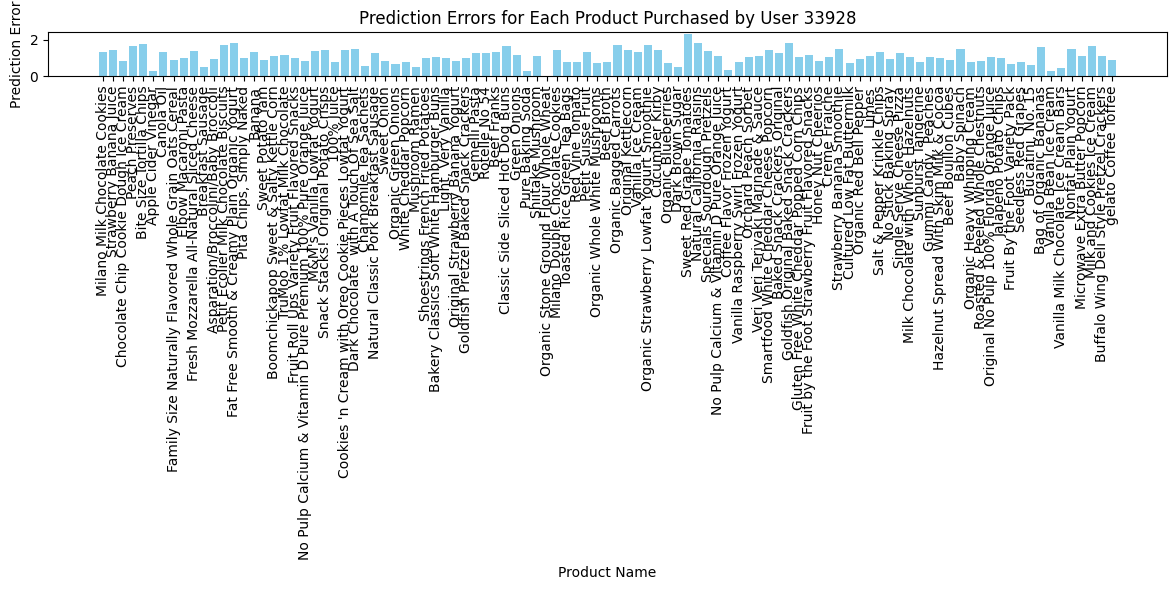

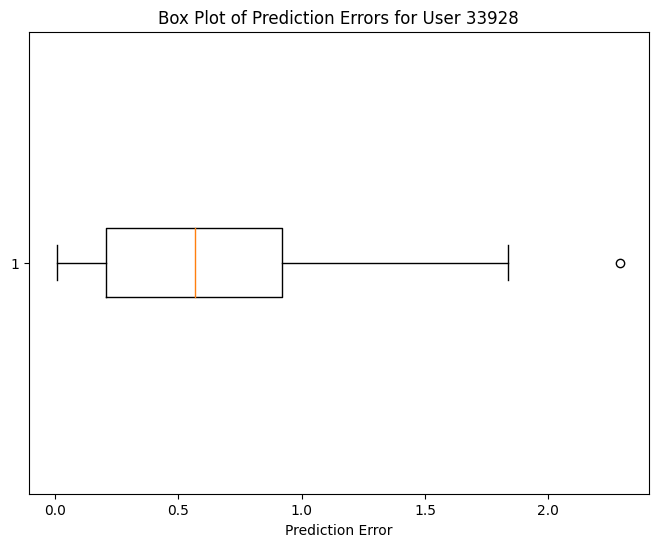

In [47]:
# Step 2: Error analysis for all items purchased by user 33928
user_33928_data['predicted_rating'] = user_33928_data['product_id'].apply(
    lambda x: algo.predict(33928, x).est
)
user_33928_data['error'] = abs(user_33928_data['predicted_rating'] - user_33928_data['rating'])

# Plotting the errors for all items
plt.figure(figsize=(12, 6))
plt.bar(user_33928_data['product_name'], user_33928_data['error'], color='skyblue')
plt.xlabel('Product Name')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors for Each Product Purchased by User 33928')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Box plot for errors
plt.figure(figsize=(8, 6))
plt.boxplot(user_33928_data['error'], vert=False)
plt.title('Box Plot of Prediction Errors for User 33928')
plt.xlabel('Prediction Error')
plt.show()

### 3.4 Hyperparameter Tuning for SVD, and saving the best model/

In [14]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10],  # Reduced from [5, 10, 20]
    'lr_all': [0.005],  # Focused on a single learning rate
    'n_factors': [50, 100]  # Reduced the range of factors
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# Use the best parameters to create a new model
best_algo = SVD(n_epochs=gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], n_factors=gs.best_params['rmse']['n_factors'])


1.029461509965582
{'n_epochs': 10, 'lr_all': 0.005, 'n_factors': 100}


### 3.5 - Running optimal SVD on the whole dataset.

In [51]:
%%time

# Re-train on the full dataset
# Use the best parameters to create a new SVD model
best_algo = SVD(n_epochs=10, lr_all=0.005, n_factors=100)



CPU times: user 30 µs, sys: 1e+03 ns, total: 31 µs
Wall time: 37 µs


In [52]:
%%time
# Train the best model on the full dataset
full_trainset = data.build_full_trainset()
best_algo.fit(full_trainset)



CPU times: user 4min 38s, sys: 4.03 s, total: 4min 42s
Wall time: 4min 42s


In [53]:
%%time

# Save the trained model to a file
import pickle
filename = 'Finalized_model.sav'
pickle.dump(best_algo, open(filename, 'wb'))

# Confirming the model is saved
"Model saved as finalized_model.sav"

CPU times: user 33.4 s, sys: 2.86 s, total: 36.3 s
Wall time: 36.3 s


'Model saved as finalized_model.sav'

In [54]:
# To load the model
loaded_model = pickle.load(open(filename, 'rb'))

### 3.6 Trying/Implementing KNN with Surprise - User-based collaborative filtering

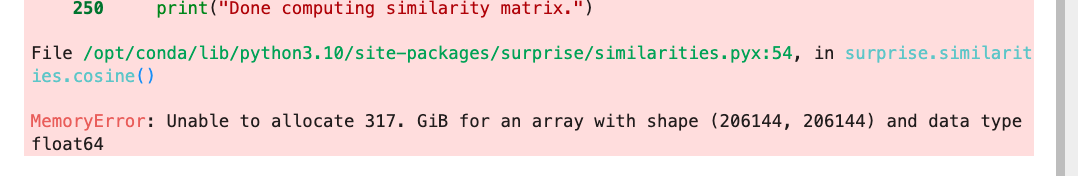

**Summary:**

#### 1. **Data Preparation and Exploration**
- You started by importing necessary libraries and setting up the environment (e.g., setting the number of processors and OpenMP threads).
- You loaded various datasets (`aisles`, `departments`, `orders`, `order_products_prior`, `order_products_train`, `products`) and performed initial merging to consolidate order and product information.
- You conducted exploratory data analysis (EDA), such as calculating the average number of products per order and visualizing the distribution of products per order.

#### 2. **Preparing Data for the Recommendation System**
- You employed the Surprise library, a toolkit for building and analyzing recommender systems, and prepared your data accordingly. This involved creating a composite 'rating' based on interactions and reorders, effectively turning implicit feedback (reorders) into explicit ratings.
- You processed the data to reflect user interactions with products, including both initial orders and reorders, to provide a nuanced dataset for training recommendation models.

#### 3. **Building Recommendation Models with Surprise**
- You utilized various algorithms available in Surprise, such as SVD (Singular Value Decomposition) to build recommendation models.
- You performed train-test splits to evaluate the models and used metrics like RMSE (Root Mean Square Error) and MAE (Mean Absolute Error) for evaluation.
- You explored hyperparameter tuning with `GridSearchCV` to find the optimal settings for the SVD model, aiming to improve prediction accuracy.

### 4. **Saving and Reusing Models**
- After identifying the best hyperparameters for the SVD model, you retrained the model on the full dataset and explored saving the trained model to disk using `pickle`, allowing for the reuse of the model without retraining.

### 5. **Exploring KNN with Surprise**
- You experimented with a user-based collaborative filtering approach using the KNNBasic algorithm, however, there are memory issues..

In [ ]:
################################

### 4.1 - Popularity Bias. and how to avoid that.

In recommendation systems, popularity bias refers to the tendency of the system to favor popular items, thereby recommending them more frequently. This bias can lead to a lack of diversity in the recommendations and may neglect long-tail, less popular items that could be of interest to specific users.

What I did to address:

- **Capping the Reorder Influence**: By capping the impact of reorders at a certain point (e.g., 5 reorders), I ensured that extremely popular items do not dominate the recommendation list solely based on their reorder count. This can help in surfacing a variety of items to the user, not just the most popular ones.

- **Balancing the Rating Scale**: A balanced rating scale, where the influence of reorders is considered but not allowed to overly skew the recommendations, can lead to a more diverse set of recommendations. It ensures that while user preferences (as indicated by reorders) are respected, they do not completely overshadow the potential discovery of new or less popular items

Potential Changes:
- **Long-Tail Promotion**: Intentionally include long-tail items (less popular or niche items) in the recommendation pool. This can involve segmenting your item dataset into popular and long-tail items and ensuring that a certain percentage of recommendations come from the long-tail segment.

### 4.2 - Potential recommendations are items with high predictions that the user hasn't purchased:

**Recap of the customer profile of the shopper.**

In [55]:
# 1) Top 10 unique products actually purchased by user 33928 and their corresponding names

# Extracting orders made by user 33928
user_33928_orders = final_merged_orders[final_merged_orders['user_id'] == 33928]

# Extracting unique products purchased by user 33928
unique_products_33928 = user_33928_orders[['product_id', 'product_name']].drop_duplicates()

# Counting the frequency of each product purchased by user 33928
product_counts_33928 = user_33928_orders.groupby(['product_id', 'product_name']).size().reset_index(name='purchase_count')

# Sorting the products by purchase frequency in descending order to get top 10 items
top_products_purchased_33928 = product_counts_33928.sort_values(by='purchase_count', ascending=False).head(5)

top_products_purchased_33928


,product_id,product_name,purchase_count
40,19934,Fat Free Smooth & Creamy Plain Organic Yogurt,20
15,6201,Bite Size Tortilla Chips,17
71,38948,Petit Ecolier Milk Chocolate Biscuits,13
12,5323,Organic Strawberry Lowfat Yogurt Smoothie,10
65,37836,Milano Milk Chocolate Cookies,10


In [56]:
import pandas as pd

# Identify all unique products in the dataset
all_products = final_merged_orders['product_id'].unique()

# Identify products purchased by user 33928
purchased_products_33928 = final_merged_orders[final_merged_orders['user_id'] == 33928]['product_id'].unique()

# Determine products not yet purchased by user 33928
unpurchased_products = set(all_products) - set(purchased_products_33928)

# List to store predictions
predictions = []


In [57]:
# Generate predictions for all unpurchased products
for product_id in unpurchased_products:
    pred = loaded_model.predict(33928, product_id)
    predictions.append((product_id, pred.est))

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['product_id', 'estimated_rating'])

# Merge with product names for readability
predictions_df = predictions_df.merge(final_merged_orders[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Sort predictions by estimated rating in descending order
top_recommendations = predictions_df.sort_values(by='estimated_rating', ascending=False).head(10)

print("Top 10 Recommended Products for User 33928:")
print(top_recommendations[['product_name', 'estimated_rating']])

Top 10 Recommended Products for User 33928:
                                           product_name  estimated_rating
34849               Oikos Fat Free Vanilla Greek Yogurt          3.853971
36623                           Purified Drinking Water          3.685043
36954                    Plain Cultured Goat Milk Kefir          3.677781
35451  Frosted Chocolate Cup Cakes  with Creamy Filling          3.636600
48119                          Almond Milk Peach Yogurt          3.606278
19016              Organic Large Extra Fancy Fuji Apple          3.592949
6269         Organic & Raw Strawberry Serenity Kombucha          3.591012
49384                            Jasmine Green Iced Tea          3.587855
8206                Zero XXX Acai Blueberry Pomegranate          3.585153
31574                        Vanilla Almond Milk Yogurt          3.583129


This is amazing! 


### 5 - Potentials for the future.. Feel like it might be better to do 1) FIRST cluster analysis, and then 2) create X separate recommendation systems.

#### 5.1 - Clustering Analysis first, we have shown previously k = 4 when analyzing the reoder

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


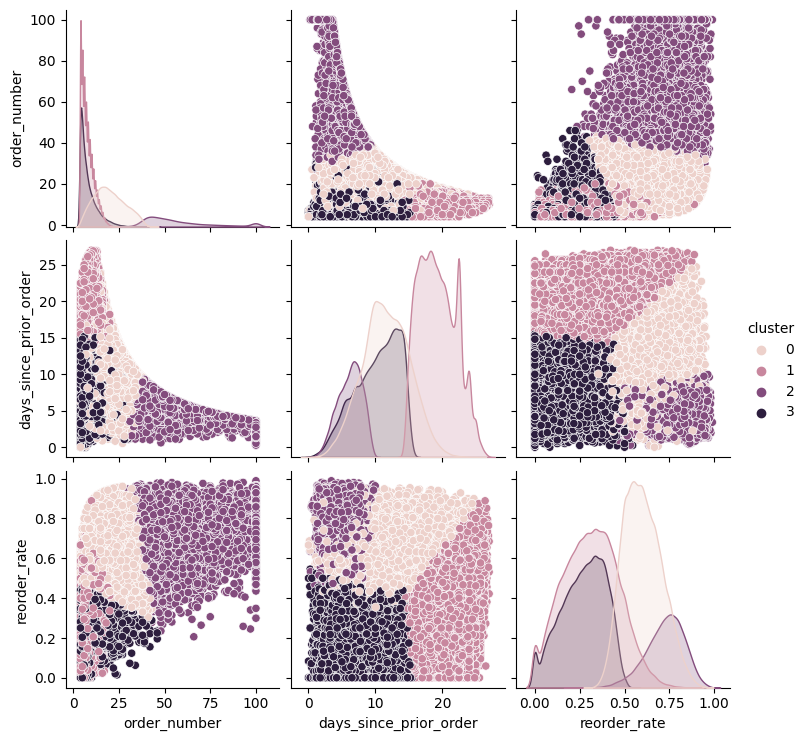

Centroids of the clusters:
   order_number  days_since_prior_order  reorder_rate
0     19.801317               11.554159      0.598499
1      7.671258               19.255048      0.309995
2     57.103882                6.138741      0.723073
3      8.257959               10.155434      0.266942


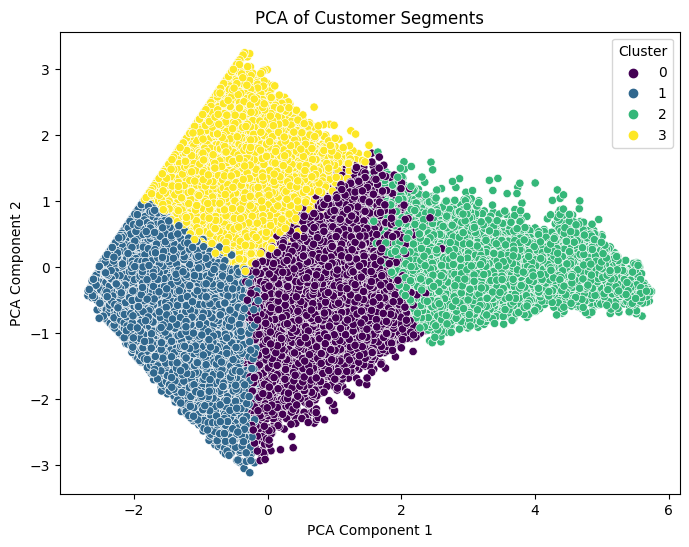

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'orders' and 'order_products_prior' are your DataFrame names
# Replace with actual DataFrame variable names if different

# Preprocessing to fill missing values
orders['days_since_prior_order'].fillna(0, inplace=True)

# Merging to get user_id for each reorder
user_reorder = pd.merge(orders, order_products_prior, on='order_id')

# Calculating reorder rates by user
user_reorder_rates = user_reorder.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_rates.rename(columns={'reordered': 'reorder_rate'}, inplace=True)

# Creating additional features for each user
order_stats = orders.groupby('user_id').agg({
    'order_number': 'max',  # Total number of orders per customer
    'days_since_prior_order': 'mean'  # Average days between orders
}).reset_index()

# Merging features with reorder rates
customer_features = pd.merge(order_stats, user_reorder_rates, on='user_id')

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['order_number', 'days_since_prior_order', 'reorder_rate']])

# Applying K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(scaled_features)

# Visualizing the clusters
sns.pairplot(customer_features, hue='cluster', vars=['order_number', 'days_since_prior_order', 'reorder_rate'])
plt.show()

# Analyzing centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['order_number', 'days_since_prior_order', 'reorder_rate'])
print("Centroids of the clusters:")
print(centroids)

# Reducing dimensions for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Scatter plot of PCA-reduced data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['cluster'], palette='viridis')
plt.title('PCA of Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


#### 5.2 - Characteristics of the 4 clusters, and picking one for further analysis

Let's focus on centroid 2 - one with the highest order numbers, lowest days since prior order, and highest reorder rate -< So the highest recency and frequency.

In [59]:

# Creating a new sub-dataset containing only data from cluster 2
cluster_2_sub_dataset = customer_features[customer_features['cluster'] == 2].copy()

# Now you have a sub-dataset 'cluster_2_sub_dataset' that contains only the entries from cluster 2.
# You can use this sub-dataset for further analysis or save it to a CSV file if needed.
cluster_2_sub_dataset_path = 'cluster_2_sub_dataset.csv'
cluster_2_sub_dataset.to_csv(cluster_2_sub_dataset_path, index=False)


#### 5.3 - Same Data Preprocessing; changing the ratings so that it makes sense.....

In [60]:
# Filtering final_merged_orders to only include users from cluster 2
final_merged_cluster2_orders = final_merged_orders[final_merged_orders['user_id'].isin(cluster_2_sub_dataset['user_id'])]
# Save to a new CSV file
final_merged_cluster2_orders_path = 'final_merged_cluster2_orders.csv'
final_merged_cluster2_orders.to_csv(final_merged_cluster2_orders_path, index=False)

In [16]:
### DO A SAMPLE(!)

Given that we have a dataset of frequent grocery shoppers, we want to prioritize user preferences as expressed through their actions on the platform.

1. **Weighted Reorder Frequency**: A higher weight could be given to reorders to signify preference. The weight could increase with the frequency of reorders, but at a diminishing rate to avoid overemphasizing items just because they are bought often.

2. **Time Decay on Reorders**: More recent reorders could be given more weight than older ones to capture changing user preferences over time.

3. **Reorder Streaks**: We could give a higher score to items that are reordered in consecutive orders, suggesting a strong and consistent preference.

4. **Combination of Reorder and Add-to-Cart Order**: Combine reorder information with the order in which the item is added to the cart. Items that are consistently added early might be considered 'staples' and could be given a higher rating.

In [63]:
final_merged_cluster2_orders.shape

(11920541, 16)

In [61]:
final_merged_cluster2_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,interaction
1606,1737705,17,prior,1,2,13,NaN,47141,2,0,Cola,77,7,soft drinks,beverages,1.0
1607,1737705,17,prior,1,2,13,NaN,7350,1,0,Natural Lime Flavor Sparkling Mineral Water,115,7,water seltzer sparkling water,beverages,1.0
1608,1737705,17,prior,1,2,13,NaN,17762,3,0,Light Oaked Chardonnay,62,5,white wines,alcohol,1.0
1609,1681401,17,prior,2,5,10,3.0,16797,5,0,Strawberries,24,4,fresh fruits,produce,1.0
1610,1681401,17,prior,2,5,10,3.0,42356,4,0,Strawberry Preserves,88,13,spreads,pantry,1.0


In [62]:
%%time

# Weighted Reorder Frequency Rating
import numpy as np
import pandas as pd
from surprise import Dataset, Reader

# Starting with the final_merged_cluster2_orders from the cluster 2
# Add a base interaction score for all orders
final_merged_cluster2_orders['interaction'] = 1.0

# Boost the interaction score by the number of reorders, with diminishing returns
final_merged_cluster2_orders['interaction'] += np.log1p(final_merged_cluster2_orders['reordered'])

# Calculate reorder frequency score
reorder_frequency = final_merged_cluster2_orders.groupby(['user_id', 'product_id'])['reordered'].sum()

# Apply a diminishing return to the reorder frequency to calculate the weight
reorder_weight = np.log1p(reorder_frequency)

# Merge the reorder weight back into the original orders data
final_data = final_merged_cluster2_orders.copy()
final_data = final_data.join(reorder_weight, on=['user_id', 'product_id'], rsuffix='_weight')

# Fill any missing weights with 1 (for items ordered only once)
final_data['reordered_weight'].fillna(1, inplace=True)

# Calculate the final rating
final_data['rating'] = final_data['interaction'] * final_data['reordered_weight']

# Define the rating scale based on the range of 'rating'
rating_scale = (final_data['rating'].min(), final_data['rating'].max())
reader = Reader(rating_scale=rating_scale)

# Load the dataset into Surprise
data = Dataset.load_from_df(final_data[['user_id', 'product_id', 'rating']], reader)

# Proceed with training models as before


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 24.9 s, sys: 4.94 s, total: 29.9 s
Wall time: 29.6 s


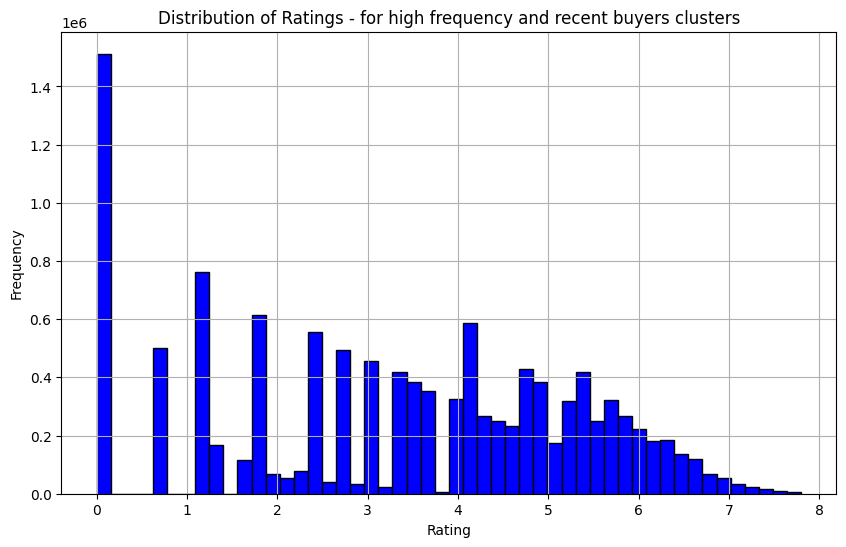

In [66]:
import matplotlib.pyplot as plt

# Assuming 'final_data' DataFrame is available with a 'rating' column
# Generate a histogram of the 'rating' distribution

plt.figure(figsize=(10, 6))
plt.hist(final_data['rating'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Ratings - for high frequency and recent buyers clusters')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [67]:
from surprise import SVD
algo = SVD()


In [68]:
# Step 1: Split the data
trainset, testset = train_test_split(data, test_size=0.25)

# Step 2: Train the SVD model
algo.fit(trainset)

# Step 3: Test the model
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9295


0.9294967237969883

For this subsection, looks to be a lot lower than the overall subset. the ratings is more customized....

In [69]:
### SAME AS OTHERS

In [70]:
### Trying Grid Search

In [71]:
%%time

from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10],  # Reduced from [5, 10, 20]
    'lr_all': [0.005],  # Focused on a single learning rate
    'n_factors': [50, 100]  # Reduced the range of factors
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

# Use the best parameters to create a new model
best_algo = SVD(n_epochs=gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], n_factors=gs.best_params['rmse']['n_factors'])


1.0267627459159
{'n_epochs': 10, 'lr_all': 0.005, 'n_factors': 100}
CPU times: user 21min 30s, sys: 17.4 s, total: 21min 47s
Wall time: 21min 44s


In [72]:
%%time

# Re-train on the full dataset
# Use the best parameters to create a new SVD model
best_algo = SVD(n_epochs=10, lr_all=0.005, n_factors=100)



CPU times: user 22 µs, sys: 1e+03 ns, total: 23 µs
Wall time: 28.6 µs


In [73]:
%%time
# Train the best model on the full dataset
full_trainset2 = data.build_full_trainset()
best_algo.fit(full_trainset2)



CPU times: user 1min 39s, sys: 76.2 ms, total: 1min 39s
Wall time: 1min 39s


In [74]:
%%time

# Save the trained model to a file
import pickle
filename = 'Finalized_model2.sav'
pickle.dump(best_algo, open(filename, 'wb'))

# Confirming the model is saved
"Model saved as finalized_model2.sav"

CPU times: user 13.8 s, sys: 1.64 s, total: 15.5 s
Wall time: 15.5 s


'Model saved as finalized_model2.sav'

In [79]:
# To load the model
loaded_model = pickle.load(open(filename, 'rb'))

In [76]:
is_user_in_data = 33928 in final_data['user_id'].values
is_user_in_data

True

Coincidentally, 33928 is also in this cluster!

In [78]:
# 1) Top 10 unique products actually purchased by user 33928 and their corresponding names

# Extracting orders made by user 33928
user_33928_orders = final_merged_cluster2_orders[final_merged_cluster2_orders['user_id'] == 33928]

# Extracting unique products purchased by user 33928
unique_products_33928 = user_33928_orders[['product_id', 'product_name']].drop_duplicates()

# Counting the frequency of each product purchased by user 33928
product_counts_33928 = user_33928_orders.groupby(['product_id', 'product_name']).size().reset_index(name='purchase_count')

# Sorting the products by purchase frequency in descending order to get top 10 items
top_products_purchased_33928 = product_counts_33928.sort_values(by='purchase_count', ascending=False).head(5)

top_products_purchased_33928


,product_id,product_name,purchase_count
40,19934,Fat Free Smooth & Creamy Plain Organic Yogurt,20
15,6201,Bite Size Tortilla Chips,17
71,38948,Petit Ecolier Milk Chocolate Biscuits,13
12,5323,Organic Strawberry Lowfat Yogurt Smoothie,10
65,37836,Milano Milk Chocolate Cookies,10


From 1st:

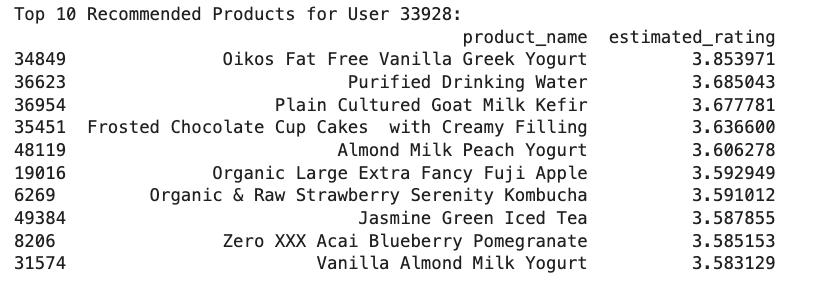

Now:

In [80]:
import pandas as pd

# Identify all unique products in the dataset
all_products = final_merged_cluster2_orders['product_id'].unique()

# Identify products purchased by user 33928
purchased_products_33928_2 = final_merged_cluster2_orders[final_merged_cluster2_orders['user_id'] == 33928]['product_id'].unique()

# Determine products not yet purchased by user 33928
unpurchased_products_2 = set(all_products) - set(purchased_products_33928_2)

# List to store predictions
predictions_2 = []
# Generate predictions for all unpurchased products
for product_id in unpurchased_products_2:
    pred = loaded_model.predict(33928, product_id)
    predictions_2.append((product_id, pred.est))

# Convert predictions to a DataFrame
predictions_df_2 = pd.DataFrame(predictions_2, columns=['product_id', 'estimated_rating'])

# Merge with product names for readability
predictions_df_2 = predictions_df_2.merge(final_merged_cluster2_orders[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Sort predictions by estimated rating in descending order
top_recommendations_2 = predictions_df_2.sort_values(by='estimated_rating', ascending=False).head(10)

print("Top 10 Recommended Products for User 33928 - 2nd model:")
print(top_recommendations_2[['product_name', 'estimated_rating']])


Top 10 Recommended Products for User 33928 - 2nd model:
                                            product_name  estimated_rating
39339                            Sparkling Mineral Water          5.195810
29322                                     Diet Coke Soda          5.022235
41907                          Gluten Free 7 Grain Bread          4.897359
183                                       Lamb Rib Chops          4.805796
36351                                    Organic 2% Milk          4.770595
7137          Grape Blended Low-Fat Greek Yogurt Pouches          4.751709
18976                 Sensitive with Iron Infant Formula          4.609827
38194                        Organic Mesa Sunrise Cereal          4.473221
28227  Organic YoKids Smoothie Strawberry Banana Lowf...          4.391784
27222             Of Maine Fresh Frozen Wild Blueberries          4.370273
